In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from rinet.metrics import bhattacharyya_gaussian_distance
from rinet.utils import correlation_to_covariance


In [2]:
errors = [
    pickle.load(open('../benchmarking/errors/simulated_1d_bd.pkl', 'rb')),
    pickle.load(open('../benchmarking/errors/simulated_2d.pkl', 'rb')),
]
    

In [5]:
# calculate reference fraction and average path-ref distances

data_dir = '../../data/'

ref_fracs = []
bd_dists = []

for dim in range(1, 3):

    means = pickle.load(open(f"{data_dir}simulated/simulated_{dim}d/test/means.pkl", 'rb'))
    stds = pickle.load(open(f"{data_dir}simulated/simulated_{dim}d/test/stds.pkl", 'rb'))
    sizes = pickle.load(open(f"{data_dir}simulated/simulated_{dim}d/test/sizes.pkl", 'rb'))
    if dim == 2:
        corr_mats = pickle.load(open(f"{data_dir}simulated/simulated_{dim}d/test/corr_mats.pkl", 'rb'))
        cov_mats = []
        for i in range(len(corr_mats)):
            cov_mats.append([correlation_to_covariance(j, k) for j, k in zip(corr_mats[i], stds[i])])
        
    ref_fracs.append([i[0]/sum(i) for i in sizes])

    bd = []
    for i in range(len(means)):
        
        if dim == 1:
            covs = []
            for j in range(len(sizes[i]) - 1):
                covs.append(np.array([stds[i][j]]))
        else:
            covs = cov_mats[i]
                        
        if len(sizes[i])-1 == 2:
            bd.append(
                bhattacharyya_gaussian_distance(
                    means[i][0],
                    covs[0],
                    means[i][1],
                    covs[1],
                )
            )
        else:
            bd.append(
                np.mean([
                    bhattacharyya_gaussian_distance(
                        means[i][0],
                        covs[0],
                        means[i][1],
                        covs[1],
                    ),
                    bhattacharyya_gaussian_distance(
                        means[i][0],
                        covs[0],
                        means[i][2],
                        covs[2],
                    )
                ])
            )
    bd_dists.append(bd)
    

In [6]:
overlaps = bd_dists
for i in range(2):
    overlaps[i] = [np.exp(-j) for j in overlaps[i]]


In [7]:
model_1 = 'rinet_v2'
model_2 = 'gmm'


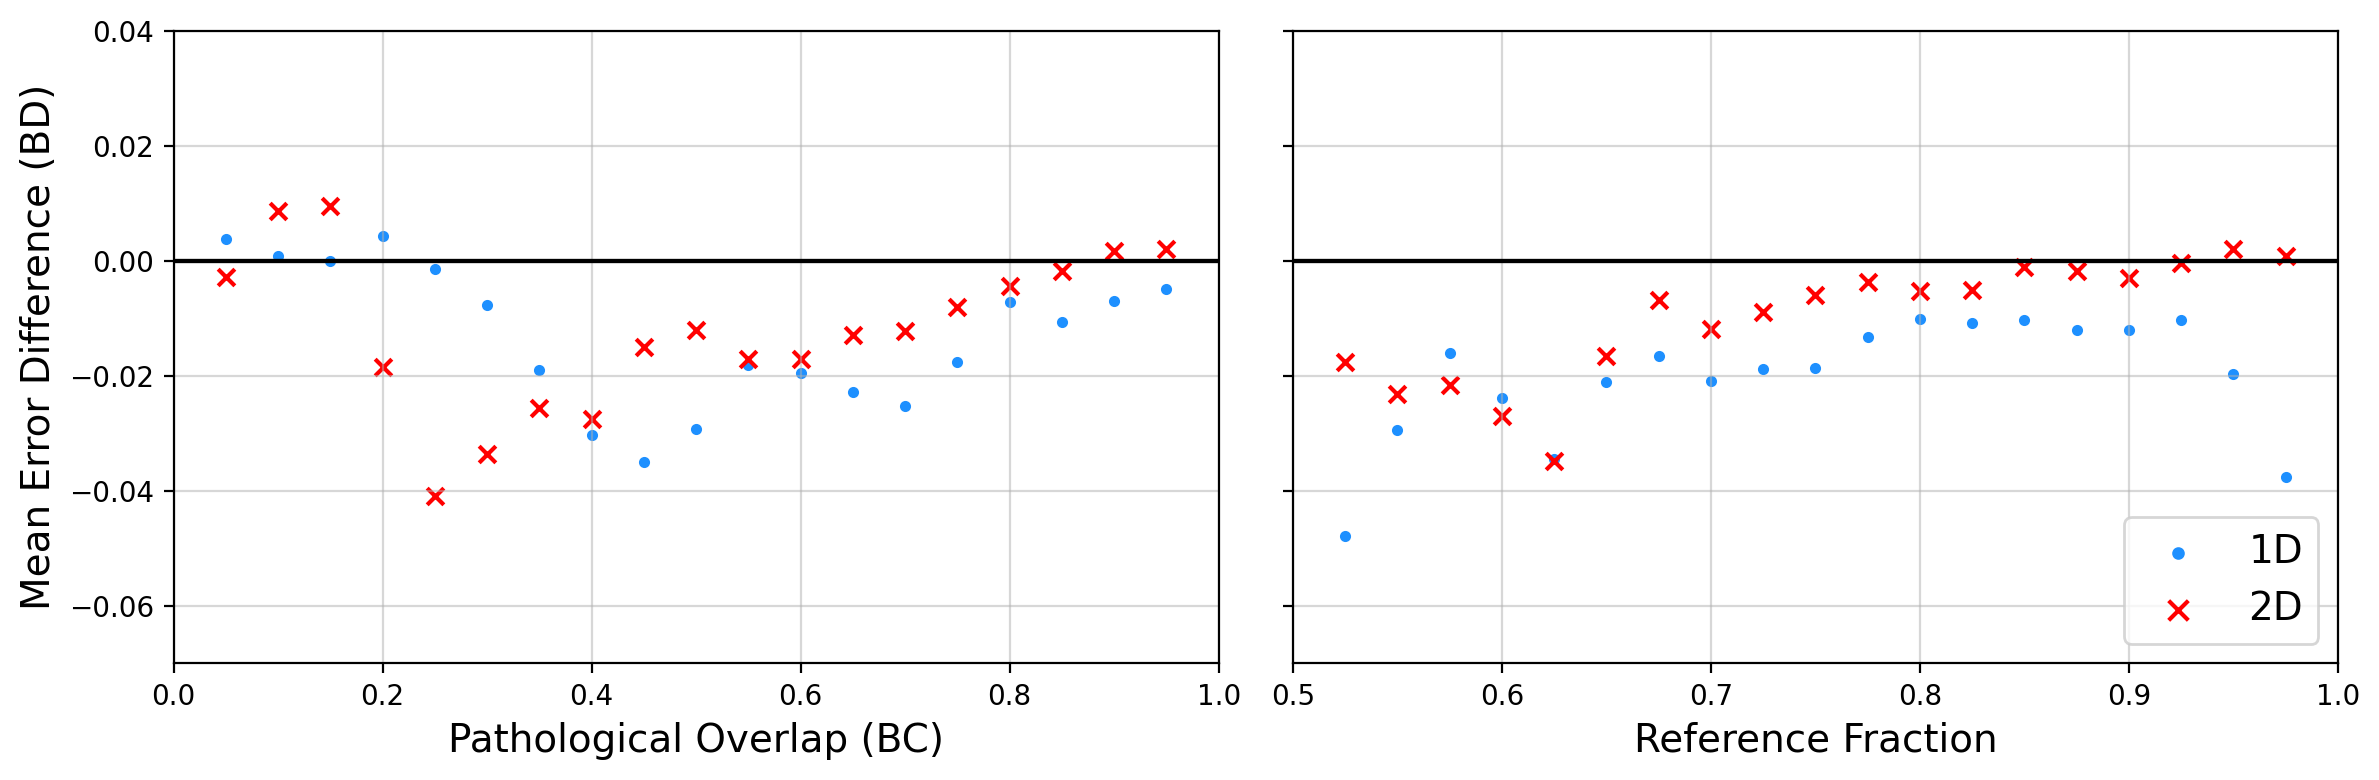

In [8]:
plt.figure(figsize=(12, 4), dpi=200)

window_bins = 2
colors = ['dodgerblue', 'red']
markers = ['.', 'x']
ylimits = [-0.07, 0.04]

for n in range(2):  # loop n dimensions

    plt.subplot(1, 2, 1)
    diffs_mean = []
    diffs_std = []
    bins = np.linspace(0, 1, 21)  # bins of overlap
    binwidth = bins[1]-bins[0]
    for i in range(len(bins)-window_bins):
        idx = np.where((overlaps[n] > bins[i]) & (overlaps[n] < bins[i + window_bins]))[0]
        diffs_mean.append(np.mean(errors[n][model_1][idx]-errors[n][model_2][idx]))
        diffs_std.append(np.std(errors[n][model_1][idx]-errors[n][model_2][idx]))
    plt.scatter(
        bins[:-window_bins]+window_bins*binwidth/2, 
        diffs_mean,
        c=colors[n], marker=markers[n])
    plt.xlabel('Pathological Overlap (BC)', fontsize=14)
    plt.ylabel('Mean Error Difference (BD)', fontsize=14)
    plt.grid(alpha=0.5);
    plt.ylim(ylimits);
    plt.axhline(0, c='k')
    plt.xlim([0, 1])

    plt.subplot(1, 2, 2)
    diffs_mean = []
    diffs_std = []
    bins = np.linspace(0.5, 1, 21)  # bins of reference fraction
    binwidth = bins[1]-bins[0]
    for i in range(len(bins)-window_bins):
        idx = np.where((ref_fracs[n] > bins[i]) & (ref_fracs[n] < bins[i + window_bins]))[0]
        diffs_mean.append(np.mean(errors[n][model_1][idx]-errors[n][model_2][idx]))
        diffs_std.append(np.std(errors[n][model_1][idx]-errors[n][model_2][idx]))
    plt.scatter(
        bins[:-window_bins]+window_bins*binwidth/2, 
        diffs_mean,
        c=colors[n], marker=markers[n])
    plt.xlabel('Reference Fraction', fontsize=14)
    plt.grid(alpha=0.5);
    plt.gca().set_yticklabels([])
    plt.ylim(ylimits);
    plt.axhline(0, c='k')
    plt.xlim([0.50, 1]);

plt.subplots_adjust(wspace=0.03)
    
plt.scatter([], [], c=colors[0], marker=markers[0], label='1D')
plt.scatter([], [], c=colors[1], marker=markers[1], label='2D')
lgnd = plt.legend(loc='lower right', fontsize=14);
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

plt.tight_layout()
plt.savefig('performance_trends.png')
